In [1]:
import pandas as pd
from hnmchallenge.data_reader import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hnmchallenge.dataset import Dataset
from hnmchallenge.models.top_pop import TopPop

In [2]:
dataset = Dataset()


In [3]:
recom = TopPop(dataset)

In [4]:
dr = DataReader()
fd = dr.get_full_data()

In [5]:
recom.recommend(interactions=fd)

1362281


 71%|███████▏  | 10/14 [15:23<06:09, 92.32s/it]


KeyboardInterrupt: 

In [26]:
import math

In [27]:
b = np.array_split(user_ids, math.ceil(len(user_ids)/500_000))

In [25]:
len(user_ids)/500_000

2.724562

In [28]:
len(b)

3

In [10]:
recom.recommend(interactions=fd)

1362281


  0%|          | 145/1000000 [00:17<32:49:48,  8.46it/s]


KeyboardInterrupt: 

In [8]:
dr = DataReader()
fd = dr.get_full_data()

In [40]:
a = np.array([1,2,3])

In [48]:
np.tile(a, (3,1))

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [38]:
b = np.array_split(fd["customer_id"].unique(), 100_00)

In [32]:
ifd = fd.set_index("customer_id")

In [39]:
ifd[ifd.index.isin(b[0])]

,t_dat,article_id,price,sales_channel_id,pop
customer_id,,,,,
0,2018-09-20,0,0.050831,2,NaN
0,2018-09-20,1,0.030492,2,NaN
1,2018-09-20,2,0.015237,2,NaN
1,2018-09-20,3,0.016932,2,NaN
1,2018-09-20,4,0.016932,2,NaN
...,...,...,...,...,...
104,2020-09-22,103004,0.016932,2,129.0
104,2020-09-22,99689,0.033881,2,712.0
104,2020-09-22,1062,0.033881,2,752.0


In [36]:
ifd.filter(items=b[0], axis=0)

/tmp/ipykernel_21996/483533743.py:1: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  ifd.filter(items=b[0], axis=0)


ValueError: cannot reindex on an axis with duplicate labels

In [21]:
(fd[fd["t_dat"] > "2020-08-31"]
        .groupby("article_id").count().reset_index().sort_values("article_id")
        )

,article_id,t_dat,customer_id,price,sales_channel_id,pop
0,27,1,1,1,1,1
1,29,1,1,1,1,1
2,33,2,2,2,2,2
3,40,1,1,1,1,1
4,52,39,39,39,39,39
...,...,...,...,...,...,...
26247,104542,1,1,1,1,1
26248,104543,1,1,1,1,1
26249,104544,2,2,2,2,2
26250,104545,1,1,1,1,1


In [9]:
fd["pop"] = (fd[fd["t_dat"] > "2020-08-31"]
        .groupby("article_id")["customer_id"].transform("count")
        )

In [10]:
item_pop = fd[["article_id", "pop"]].drop_duplicates().fillna(0)

In [16]:
item_pop["pop"].values.shape

(128104,)

In [19]:
np.repeat(item_pop["pop"].values, 2, axis=0).shape

(256208,)

In [20]:
a = 100_000

In [21]:
a

100000

In [33]:
fd[["customer_id"]].drop_duplicates()

,customer_id
0,0
2,1
7,2
12,3
14,4
...,...
31788165,1362276
31788202,1362277
31788208,1362278
31788217,1362279


In [27]:
item_pop.sort_values("article_id")

,article_id,pop
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
31785745,104542,1.0
31785950,104543,1.0
31785951,104544,2.0
31786216,104545,1.0


In [17]:
fd_s = fd.sort_values("article_id").fillna(0)

In [18]:
fd_s

,t_dat,customer_id,article_id,price,sales_channel_id,pop
0,2018-09-20,0,0,0.050831,2,0.0
5147600,2019-01-18,297211,0,0.030492,2,0.0
1975839,2018-10-31,195483,0,0.050831,2,0.0
5125138,2019-01-18,179930,0,0.027102,1,0.0
5121068,2019-01-18,410484,0,0.027102,1,0.0
...,...,...,...,...,...,...
31785950,2020-09-22,1362203,104543,0.038119,1,1.0
31785952,2020-09-22,1362203,104544,0.016000,1,2.0
31785951,2020-09-22,1362203,104544,0.016017,1,2.0
31786216,2020-09-22,261358,104545,0.033881,2,1.0


In [3]:
dr.get_zero_interatction_users()

,customer_id
0,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...
1,000df4d2084d142416b8165bdd249bab8fea2393447aed...
2,00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...
3,001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...
4,002648d8f3b288531b24860f4a68a31d029ec5a0495c04...
...,...
9694,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...
9695,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...
9696,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...
9697,fffa8d3cea26d4f5186472b923629b35fa28051f258030...


In [4]:
full_raw_data = dr.get_transactions()

In [6]:
train_c = full_raw_data["customer_id"].unique()

In [13]:
c = dr.get_target_user()

In [16]:
c

,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...


In [17]:
set_train_c = set(train_c)
set_c = set(c["customer_id"])
intersection = set_train_c.intersection(set_c)

In [3]:
import numpy as np
np.array(set([1,2,3]))

array({1, 2, 3}, dtype=object)

In [30]:
from hnmchallenge.constant import *
dr = DataReader()
ss = dr.get_sample_submission()
target_user = ss[[DEFAULT_USER_COL]]
full_raw_data = dr.get_transactions()
unique_train_user = full_raw_data["customer_id"].unique()

full_user_set = set(target_user[DEFAULT_USER_COL])
train_user_set = set(unique_train_user)
zero_int_users = np.array((full_user_set - train_user_set))
zero_int_users_df = (
    pd.Series(zero_int_users, name=DEFAULT_USER_COL)
    .to_frame()
    .reset_index(drop=True)
)

In [37]:
target_user[~target_user["customer_id"].isin(unique_train_user)]

,customer_id
131,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...
297,000df4d2084d142416b8165bdd249bab8fea2393447aed...
544,00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...
671,001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...
809,002648d8f3b288531b24860f4a68a31d029ec5a0495c04...
...,...
1371440,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...
1371554,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...
1371739,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...
1371872,fffa8d3cea26d4f5186472b923629b35fa28051f258030...


In [32]:
target_user


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...


In [23]:
9699/len(set_c)

0.0070693450341841714

In [3]:
from hnmchallenge.dataset import Dataset

In [4]:
d = Dataset()
tr,v,te = d.load_splits()

In [6]:
len(tr)

31256357

In [4]:
from hnmchallenge.utils.interaction_matrix import interactions_to_sparse_matrix

In [5]:
r = interactions_to_sparse_matrix(fd, users_num=1362281, items_num=104547)

In [7]:
from sparsesvd import sparsesvd

In [8]:
csc_int_m = r.tocsc()

In [9]:
ut, s, vt = sparsesvd(csc_int_m, 100)

In [11]:
ut.shape

(100, 1362281)

In [12]:
vt.shape

(100, 104547)

In [25]:
train_small_df = fd[
    (fd["t_dat"] > "2020-07-30") & (fd["t_dat"] < "2020-09-8")
]

In [30]:
train_small_df.reset_index(drop=True)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-07-31,481512,89423,0.016932,1
1,2020-07-31,481512,88336,0.025407,1
2,2020-07-31,481512,85951,0.018627,1
3,2020-07-31,1321127,81136,0.016932,2
4,2020-07-31,1321127,81073,0.016932,2
...,...,...,...,...,...
1542193,2020-09-07,221114,100706,0.082305,1
1542194,2020-09-07,221114,77668,0.065864,1
1542195,2020-09-07,221114,96892,0.016441,1
1542196,2020-09-07,221114,97502,0.032915,1


In [27]:
len(train_small_df)

1542198

In [24]:
len(fd["customer_id"].unique())

1362281

In [21]:
test = fd[fd["t_dat"] > "2020-09-14"]
val = fd[(fd["t_dat"] > "2020-09-7") & (fd["t_dat"] < "2020-09-15")]
train = fd[(fd["t_dat"] < "2020-09-8")]

In [23]:
len(train["article_id"].unique())

102858

In [13]:
train

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,0,0,0.050831,2
1,2018-09-20,0,1,0.030492,2
2,2018-09-20,1,2,0.015237,2
3,2018-09-20,1,3,0.016932,2
4,2018-09-20,1,4,0.016932,2
...,...,...,...,...,...
31256352,2020-09-07,221114,100706,0.082305,1
31256353,2020-09-07,221114,77668,0.065864,1
31256354,2020-09-07,221114,96892,0.016441,1
31256355,2020-09-07,221114,97502,0.032915,1


In [7]:
fd["t_dat"].max()

Timestamp('2020-09-22 00:00:00')

In [9]:
len(val)

265603

In [10]:
len(test)

266364

In [11]:
len(train)

31256357

In [12]:
fd = fd.set_index("article_id")

In [118]:
fd['Counts'] = fd.groupby(['article_id'])['customer_id'].transform('count')

In [119]:
fd = fd.reset_index()

In [100]:
fd

,article_id,t_dat,customer_id,price,sales_channel_id,Counts
0,0,2018-09-20,0,0.050831,2,633
1,1,2018-09-20,0,0.030492,2,434
2,2,2018-09-20,1,0.015237,2,42
3,3,2018-09-20,1,0.016932,2,1836
4,4,2018-09-20,1,0.016932,2,1792
...,...,...,...,...,...,...
31788319,102734,2020-09-22,212537,0.059305,2,193
31788320,97490,2020-09-22,212537,0.042356,2,513
31788321,104185,2020-09-22,1090369,0.043203,1,6
31788322,70100,2020-09-22,729233,0.006763,1,866


In [120]:
mm = fd.groupby(['article_id', pd.Grouper(key='t_dat', freq='W-MON')])["price"].count().reset_index().sort_values("t_dat")

In [123]:
final = mm.merge(fd, on="article_id", how="left")

In [121]:
mm

,article_id,t_dat,price
0,0,2018-09-24,38
398675,11795,2018-09-24,2
398692,11796,2018-09-24,4
398715,11797,2018-09-24,13
398733,11798,2018-09-24,4
...,...,...,...
1884878,78584,2020-09-28,8
2193081,99602,2020-09-28,11
2110488,91323,2020-09-28,1
1883534,78524,2020-09-28,1


In [105]:
fd["norm_count"] = fd["rolling_count"]/fd["Counts"]

In [106]:
fd = fd.sort_values("t_dat")

In [112]:
fd

,article_id,t_dat,customer_id,price,sales_channel_id,Counts,rolling_count,norm_count
0,0,2018-09-20,0,0.050831,2,633,38,0.060032
32262,715,2018-09-20,9307,0.042356,2,391,34,0.086957
32263,2853,2018-09-20,9307,0.025407,2,413,30,0.072639
32264,9513,2018-09-20,9308,0.016949,1,86,1,0.011628
32265,9514,2018-09-20,9308,0.033898,1,60,1,0.016667
...,...,...,...,...,...,...,...,...
31766405,102776,2020-09-22,600802,0.025407,1,190,19,0.100000
31766404,76287,2020-09-22,600802,0.067780,1,1671,22,0.013166
31766403,103519,2020-09-22,173692,0.025407,1,73,11,0.150685
31766497,103319,2020-09-22,1119606,0.067780,2,233,7,0.030043


(array([17805., 17897., 17987., 18078., 18170., 18262., 18353., 18444.,
        18536.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

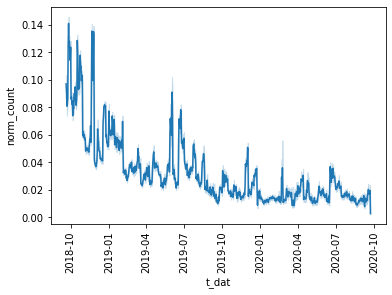

In [113]:
sns.lineplot(data=fd[fd["article_id"].isin(np.arange(10000,12000))], x="t_dat", y="norm_count")
plt.xticks(rotation="vertical")

In [60]:
mfreq = mfreq.rename(columns={"price":"rolling_count"})

In [61]:
mfreq

,t_dat,article_id,rolling_count
0,2018-09-24,0,38
398675,2018-09-24,11795,2
398692,2018-09-24,11796,4
398715,2018-09-24,11797,13
398733,2018-09-24,11798,4
...,...,...,...
1884878,2020-09-28,78584,8
2193081,2020-09-28,99602,11
2110488,2020-09-28,91323,1
1883534,2020-09-28,78524,1


In [62]:
mfreq = mfreq.set_index("article_id")

In [63]:
mfreq

,t_dat,rolling_count
article_id,,
0,2018-09-24,38
11795,2018-09-24,2
11796,2018-09-24,4
11797,2018-09-24,13
11798,2018-09-24,4
...,...,...
78584,2020-09-28,8
99602,2020-09-28,11
91323,2020-09-28,1


In [67]:
mfreq

,t_dat,rolling_count
article_id,,
0,2018-09-24,38
11795,2018-09-24,2
11796,2018-09-24,4
11797,2018-09-24,13
11798,2018-09-24,4
...,...,...
78584,2020-09-28,8
99602,2020-09-28,11
91323,2020-09-28,1


In [68]:
fd

,t_dat,customer_id,price,sales_channel_id
article_id,,,,
0,2018-09-20,0,0.050831,2
1,2018-09-20,0,0.030492,2
2,2018-09-20,1,0.015237,2
3,2018-09-20,1,0.016932,2
4,2018-09-20,1,0.016932,2
...,...,...,...,...
102734,2020-09-22,212537,0.059305,2
97490,2020-09-22,212537,0.042356,2
104185,2020-09-22,1090369,0.043203,1


In [65]:
mm = mfreq.merge(fd,on="article_id", how="left")

In [66]:
mm

,t_dat_x,rolling_count,t_dat_y,customer_id,price,sales_channel_id
article_id,,,,,,
0,2018-09-24,38,2018-09-20,0,0.050831,2
0,2018-09-24,38,2018-09-20,2960,0.049475,2
0,2018-09-24,38,2018-09-20,4344,0.050831,2
0,2018-09-24,38,2018-09-20,5973,0.050831,1
0,2018-09-24,38,2018-09-20,7672,0.050831,2
...,...,...,...,...,...,...
78524,2020-09-28,1,2020-09-18,1099007,0.013542,1
78524,2020-09-28,1,2020-09-19,504886,0.013542,1
78524,2020-09-28,1,2020-09-20,70013,0.013542,1


In [4]:
fd

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,0,0,0.050831,2
1,2018-09-20,0,1,0.030492,2
2,2018-09-20,1,2,0.015237,2
3,2018-09-20,1,3,0.016932,2
4,2018-09-20,1,4,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,212537,102734,0.059305,2
31788320,2020-09-22,212537,97490,0.042356,2
31788321,2020-09-22,1090369,104185,0.043203,1
31788322,2020-09-22,729233,70100,0.006763,1


In [4]:
fd.dtypes

t_dat                object
customer_id           int64
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [20]:
date = pd.to_datetime(fd["t_dat"])

In [23]:
fd["t_dat"] = pd.to_datetime(fd["t_dat"])

(array([17805., 17897., 17987., 18078., 18170., 18262., 18353., 18444.,
        18536.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

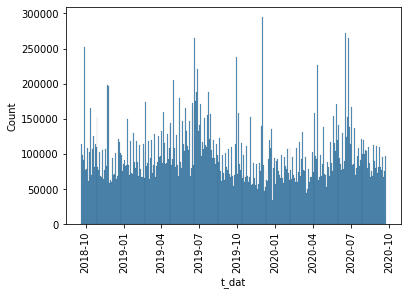

In [25]:
sns.histplot(data=fd, x="t_dat")
plt.xticks(rotation="vertical")

In [21]:
date.max()

Timestamp('2020-09-22 00:00:00')

In [22]:
date.min()

Timestamp('2018-09-20 00:00:00')

In [5]:
fd["t_dat"].max()

'2020-09-22'

In [8]:
test = fd[fd["t_dat"] > "2020-09-15"]
val = fd[(fd["t_dat"] > "2020-09-8") & (fd["t_dat"] < "2020-09-16")]
train = fd[(fd["t_dat"] < "2020-09-9")]

In [14]:
train_small = fd[(fd["t_dat"] > "2020-05-30") & (fd["t_dat"] < "2020-09-9")]

In [17]:
fd = fd.groupby(['article_id', pd.Grouper(key='t_dat', freq='W-MON')]).count().reset_index().sort_values('t_dat')

,article_id,t_dat,customer_id,price,sales_channel_id
0,0,2018-09-24,38,38,38
398675,11795,2018-09-24,2,2,2
398692,11796,2018-09-24,4,4,4
398715,11797,2018-09-24,13,13,13
398733,11798,2018-09-24,4,4,4
...,...,...,...,...,...
1884878,78584,2020-09-28,8,8,8
2193081,99602,2020-09-28,11,11,11
2110488,91323,2020-09-28,1,1,1
1883534,78524,2020-09-28,1,1,1


In [32]:
item_subset = np.arange(50,52)
filtered_fd = fd[fd["article_id"].isin(item_subset)]

(array([17805., 17897., 17987., 18078., 18170., 18262., 18353., 18444.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

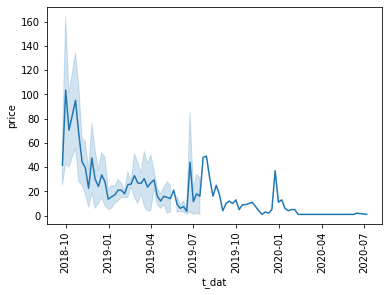

In [34]:
sns.lineplot(data=filtered_fd, x="t_dat", y="price")
plt.xticks(rotation="vertical")

In [15]:
len(train_small)

4687752

In [6]:
len(val)

255241

In [7]:
len(test)

240311

In [3]:
tr = dr.get_transactions()

In [7]:
tr["t_dat"].min()

'2018-09-20'

In [6]:
tr["t_dat"].max()

'2020-09-22'

In [3]:
tr = dr.get_transactions()

In [15]:
tr.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [13]:
tr.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [5]:
dr.get_articles()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Large plastic hair claw.


In [9]:
type(tr.head()["article_id"].values[0])

numpy.int64

In [ ]:
type(dr.get_sample_submission().head()["prediction"].values[0])

In [10]:
ss = dr.get_sample_submission()

In [12]:
ss.head()["prediction"].values[0]

'0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001'

In [ ]:
a,b = dr.get_new_raw_mapping_dict()

In [ ]:
a = np.array([1,2,3])

In [ ]:
" ".join(map(str, a))

In [ ]:
dr.get_sample_submission()["prediction"].values

In [ ]:
tr=dr.get_transactions()

In [ ]:
tr["article_id"]

In [ ]:
transaction = dr.get_full_data()

In [ ]:
transaction.columns

In [ ]:
transaction["t_dat"].min()

In [ ]:
transaction["t_dat"].max()

In [ ]:
transaction[transaction["t_dat"] > "2020-07-22"].groupby("article_id").count().sort_values("t_dat", ascending = False).iloc[0:12].index.values

In [ ]:
ss = dr.get_sample_submission()

In [ ]:
ss["prediction"].values[0]

In [ ]:
transactions = dr.get_transactions()

In [ ]:
unique_user_ids = transactions["customer_id"].unique()

In [ ]:
mapped_ids = np.arange(len(unique_user_ids))

In [ ]:
raw_new_ids_mapping_dict = dict(zip(unique_user_ids, mapped_ids))
new_raw_ids_mapping_dict = {v: k for k,v in raw_new_ids_mapping_dict.items()}

In [ ]:
new_raw_ids_mapping_dict

In [ ]:
transactions.columns

In [ ]:
sns.histplot(transactions.sort_values(by="article_id"), x="article_id")

In [ ]:
count = transactions.groupby("article_id").count()

In [ ]:
y = count.sort_values("t_dat", ascending=False)["t_dat"]
x = np.arange(len(y))

In [ ]:
plt.plot(x, y)

In [ ]:
user_count = transactions.groupby("customer_id").count()

In [ ]:
y_2 = user_count.sort_values("t_dat", ascending=False)["t_dat"]

In [ ]:
x_2 = np.arange(len(y_2))
plt.plot(x_2, y_2)

In [ ]:
transactions["t_dat"].min()

In [ ]:
transactions["t_dat"].max()

In [ ]:
last_slice = transactions[transactions["t_dat"] > "2020-07-22"]

In [ ]:
last_slice

In [ ]:
len(last_slice["article_id"].unique())